# Lab 1. Node embeddings

In [1]:
import networkx as nx
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.optim import SGD
import random

## 1. Подготовка данных

Для реализации задач лабораторной возьмем граф Karate Club Network, показывающий кто из учеников общается вне занятий. После конфликта администратора и инструктора такой граф был использован для разделения учеников на два новых клуба.

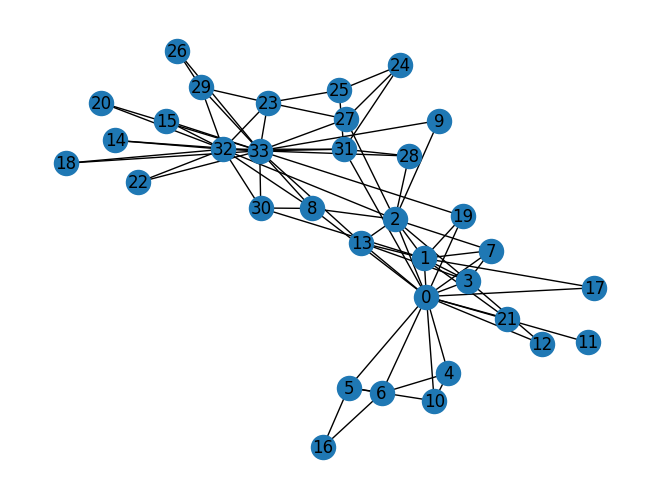

In [2]:
G = nx.karate_club_graph()
# Визуализируем граф
nx.draw(G, with_labels = True)

In [3]:
def graph_to_edge_list(G):
    # Функция, которая преобразует граф G в список рёбер.
    # Возвращает список всех рёбер графа в виде списка кортежей (edge_list).
    return list(G.edges())

def edge_list_to_tensor(edge_list):
    # Функция, которая преобразует edge_list в тензор.
    # Входной edge_list представляет собой список кортежей, а результатом является тензор формы [2, len(edge_list)].

    # Создаём тензор из списка рёбер и меняем его размерность с помощью permute, чтобы получить нужную форму [2, num_edges].
    edge_index = torch.tensor(edge_list, dtype=torch.long).permute((1, 0))

    return edge_index

# Преобразуем граф в список положительных рёбер
pos_edge_list = graph_to_edge_list(G)

# Преобразуем список рёбер в тензор
pos_edge_index = edge_list_to_tensor(pos_edge_list)

# Выводим форму и сумму значений тензора рёбер
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))


The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


In [4]:
def sample_negative_edges(G, num_neg_samples):
    # Функция, которая генерирует список отрицательных рёбер.
    # Количество отрицательных рёбер задаётся параметром num_neg_samples.

    neg_edge_list = []  # Инициализируем список для хранения отрицательных рёбер

    pos_set = set(G.edges())  # Создаём множество положительных рёбер для быстрой проверки

    while len(neg_edge_list) < num_neg_samples:
        # Выбираем две случайные вершины из графа
        random_pair = np.random.choice(G.nodes(), 2)
        u, v = random_pair[0], random_pair[1]

        # Проверяем, что выбранные вершины не образуют петлю и что рёбра (u, v) и (v, u) не являются положительными рёбрами
        if u == v or (u, v) in pos_set or (v, u) in pos_set:
            continue
        # Проверяем, что рёбра (u, v) и (v, u) ещё не добавлены в список отрицательных рёбер
        if (u, v) in neg_edge_list or (v, u) in neg_edge_list:
            continue

        # Добавляем отрицательное ребро в список
        neg_edge_list.append((u, v))

    return neg_edge_list  # Возвращаем список отрицательных рёбер

# Устанавливаем фиксированное начальное значение для генератора случайных чисел
np.random.seed(20)

# Генерируем 78 отрицательных рёбер
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Преобразуем список отрицательных рёбер в тензор
neg_edge_index = edge_list_to_tensor(neg_edge_list)

# Выводим форму тензора отрицательных рёбер
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))


The neg_edge_index tensor has shape torch.Size([2, 78])


In [5]:
# Функция для визуализации
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="John A")
  plt.legend()
  plt.show()

In [6]:
def Loss(emb, pos_nodes, neg_nodes):
    V = len(emb.weight.data)  # количество узлов в графе
    L = 0

    # Цикл по всем узлам
    for u in range(V):
        Nr_u = pos_nodes[u]  # положительные узлы для вершины u
        for v in Nr_u:
            # Вычисляем скалярное произведение векторов для положительных узлов
            ZuT_Zv = torch.sum(torch.mul(emb.weight[u], emb.weight[int(v)]), axis=0)
            L += torch.log(torch.sigmoid(ZuT_Zv))

        # Непосещённые вершины (отрицательные выборки)
        for i in neg_nodes[u]:
            ZuT_ZTi = torch.sum(torch.mul(emb.weight[u], emb.weight[int(i)]), axis=0)
            L += torch.log(torch.sigmoid(-ZuT_ZTi))

    return -L  # Возвращаем отрицательное значение ошибки для минимизации


import matplotlib.pyplot as plt

def train(emb, pos_nodes, neg_nodes):
    epochs = 100
    learning_rate = 0.01
    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)
    loss_values = []  # Список для сохранения значений ошибки на каждой эпохе

    for i in range(epochs):
        optimizer.zero_grad()  # Обнуляем градиенты перед каждым шагом оптимизации
        loss = Loss(emb, pos_nodes, neg_nodes)  # Вычисляем ошибку
        loss.backward()  # Вычисляем градиенты
        optimizer.step()  # Обновляем параметры

        # Сохраняем значение ошибки для построения графика
        loss_values.append(loss.item())

        # Визуализация эмбеддингов на каждой 20-й эпохе
        if i % 20 == 0:
            with torch.no_grad():
                visualize_emb(emb)
                print("Эпоха {}: Ошибка = {}".format(i, loss.item()))
    print("Эпоха {}: Ошибка = {}".format(i, loss.item()))

    # Построение графика изменения ошибки по эпохам
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), loss_values, label="Ошибка")
    plt.xlabel("Эпоха")
    plt.ylabel("Значение ошибки")
    plt.title("Изменение ошибки во время обучения")
    plt.legend()
    plt.show()



# DeepWalk

In [19]:
def DeepWalk(G, num_of_paths=10, len_of_path=10, t=5):
    # Получаем количество узлов в графе и инициализируем слой эмбеддингов
    num_of_nodes = G.number_of_nodes()
    emb = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes)

    # Массивы для хранения посещённых и непосещённых вершин
    positive_nodes = []  # массив вершин, которые встретились при обходе
    negative_nodes = []  # массив из t случайных вершин, которые не встретились

    # Цикл по всем вершинам графа
    for i in range(num_of_nodes):
        temp_emb = np.zeros(num_of_nodes)  # частота посещения каждой вершины
        temp_pos_nodes = []  # массив посещённых вершин
        temp_neg_nodes = np.zeros(t)  # массив из t непосещённых вершин

        # Цикл по количеству блужданий для каждой вершины
        for _ in range(num_of_paths):
            temp_node = i  # текущая вершина
            nodes_in_path = set()  # множество посещённых вершин
            nodes_in_path.add(temp_node)

            # Генерация случайного пути
            for _ in range(len_of_path):
                avail_neighb = list(G.neighbors(temp_node))  # доступные соседи
                if not avail_neighb:
                    break
                next_node = random.choice(avail_neighb)  # выбираем следующий узел случайно
                nodes_in_path.add(next_node)
                temp_node = next_node  # обновляем текущую вершину

            # Обновляем частоту посещения вершин в текущем блуждании
            for node in nodes_in_path:
                temp_emb[node] += 1
                temp_pos_nodes.append(node)

        # Заполняем массив отрицательных выборок (непосещённых вершин)
        neg_samples = [j for j in range(len(temp_emb)) if temp_emb[j] == 0]
        for j in range(t):
            temp_neg_nodes[j] = random.choice(neg_samples)

        # Нормируем и сохраняем эмбеддинги для текущей вершины
        emb.weight.data[i] = torch.Tensor(temp_emb / num_of_paths)
        positive_nodes.append(temp_pos_nodes)
        negative_nodes.append(temp_neg_nodes)

    return emb, positive_nodes, np.array(negative_nodes)

In [20]:
emb, pos_nodes, neg_nodes = DeepWalk(G)

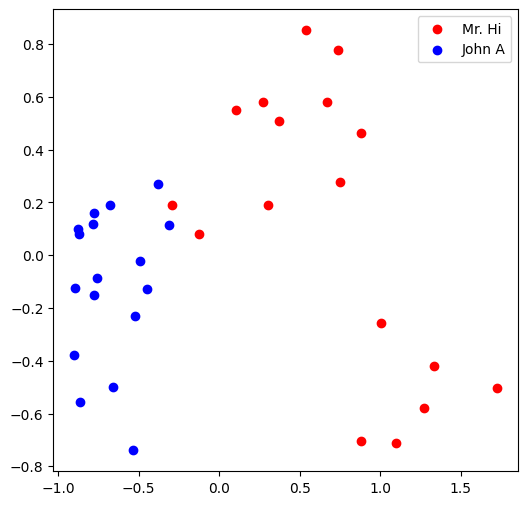

Эпоха 0: Ошибка = 536.5673828125


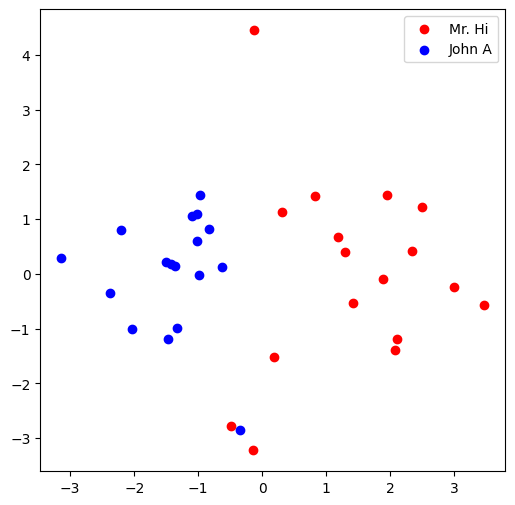

Эпоха 20: Ошибка = 200.47625732421875


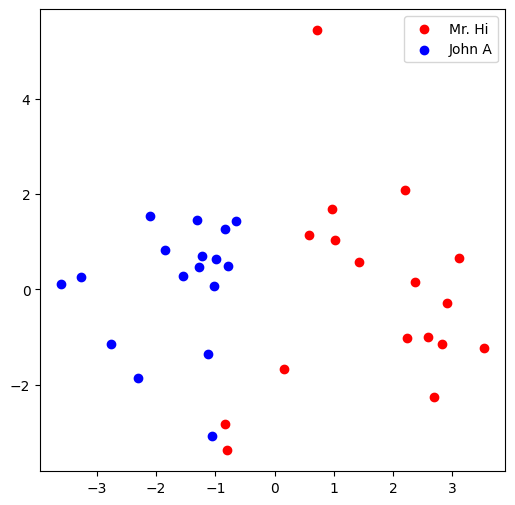

Эпоха 40: Ошибка = 178.1089324951172


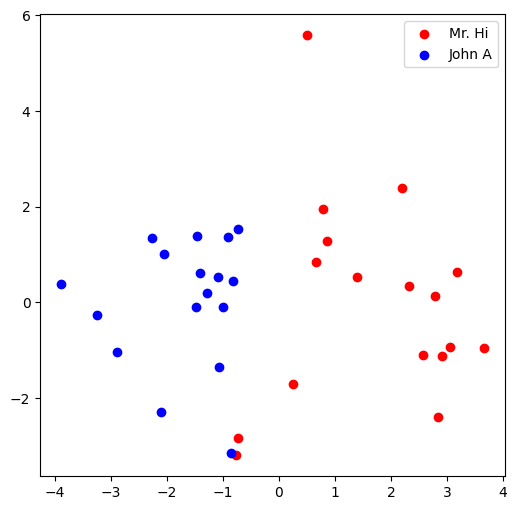

Эпоха 60: Ошибка = 176.22605895996094


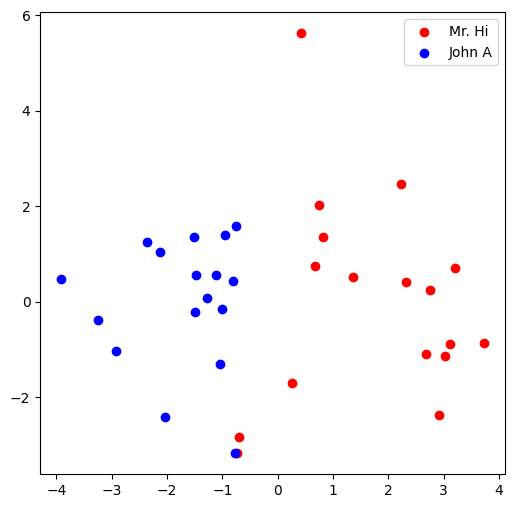

Эпоха 80: Ошибка = 175.85995483398438
Эпоха 99: Ошибка = 175.7784423828125


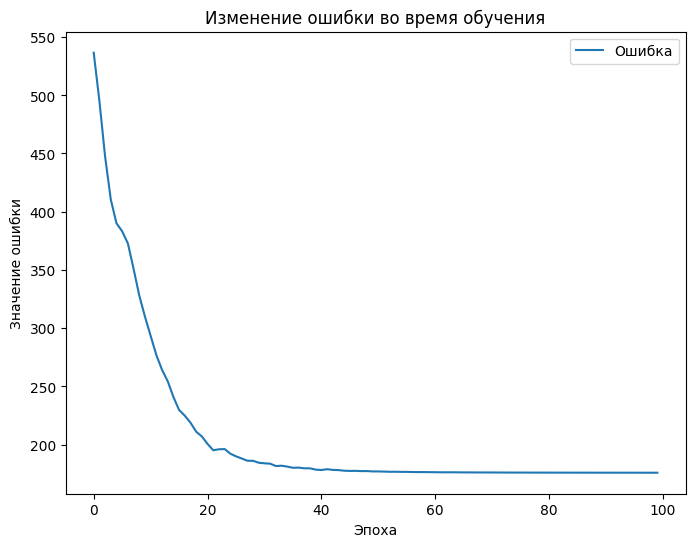

In [21]:
# Запускаем обучение
train(emb, pos_nodes, neg_nodes)

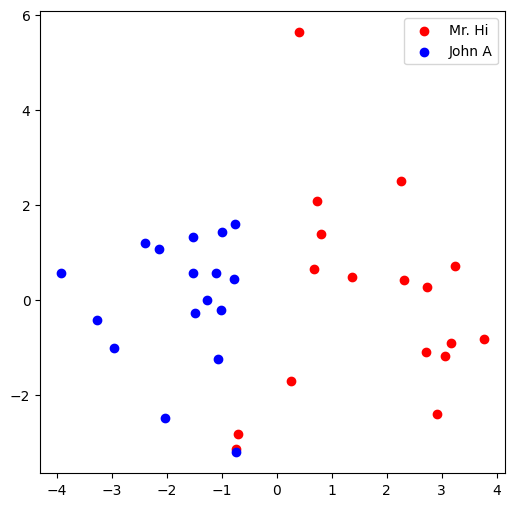

In [22]:
visualize_emb(emb)

В целом, визуальная классификация довольно хорошо прослеживается. Лосс после 40 эпохи почти не снижается.

# Node2Vec

In [27]:
def Node2Vec(G, num_of_paths=10, len_of_path=10, t=5, p=1, q=0.5):
    # Получаем число узлов в графе
    num_of_nodes = G.number_of_nodes()

    # Создаём слой для эмбеддингов узлов
    emb = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes)

    positive_nodes = []  # для хранения узлов, встреченных при обходе
    negative_nodes = []  # для хранения t случайных узлов, которых не встретили

    # Проходим по всем узлам графа
    for i in range(num_of_nodes):
        freq_table = np.zeros(num_of_nodes)  # счётчик посещений для каждого узла
        encountered_nodes = []  # временное хранилище для посещённых узлов
        negative_sample_nodes = np.zeros(t)  # хранилище для узлов, которые не посещены

        previous_node = i  # сохраняем предыдущий узел
        previous_neighbors = set()  # хранилище для соседей предыдущего узла

        # Прогоняем блуждание num_of_paths раз от текущего узла
        for _ in range(num_of_paths):
            current_node = i  # стартуем с текущего узла
            path_nodes = set()  # множество для узлов, пройденных на пути
            path_nodes.add(current_node)

            # Выполняем блуждание по графу на len_of_path шагов
            for _ in range(len_of_path):
                # Формируем список соседей для перехода с учётом параметров p и q
                candidate_neighbors = []
                for neighbor in G.neighbors(current_node):
                    if neighbor == previous_node:
                        candidate_neighbors.extend([neighbor] * int(1 / p))
                    elif neighbor in previous_neighbors:
                        candidate_neighbors.append(neighbor)
                    else:
                        candidate_neighbors.extend([neighbor] * int(1 / q))

                # Выбираем следующий узел случайным образом из возможных соседей
                next_node = random.choice(candidate_neighbors)

                # Обновляем информацию о пройденных узлах и соседях
                path_nodes.add(next_node)
                previous_node = current_node
                current_node = next_node
                previous_neighbors.update(candidate_neighbors)

            # Заполняем счётчик посещений на основе пройденного пути
            for node in path_nodes:
                freq_table[node] += 1
                encountered_nodes.append(node)

        # Находим узлы, которые не были посещены
        unvisited_nodes = [j for j, freq in enumerate(freq_table) if freq == 0]

        # Случайно выбираем t узлов из списка непосещённых
        for idx in range(t):
            negative_sample_nodes[idx] = random.choice(unvisited_nodes)

        # Обновляем слой эмбеддингов на основе частоты посещений
        emb.weight.data[i] = torch.Tensor(freq_table / num_of_paths)

        # Сохраняем информацию о посещённых и непосещённых узлах для текущего узла
        positive_nodes.append(encountered_nodes)
        negative_nodes.append(negative_sample_nodes)

    return emb, positive_nodes, np.array(negative_nodes)


In [28]:
emb_n2v, pos_nodes_n2v, neg_nodes_n2v = Node2Vec(G)

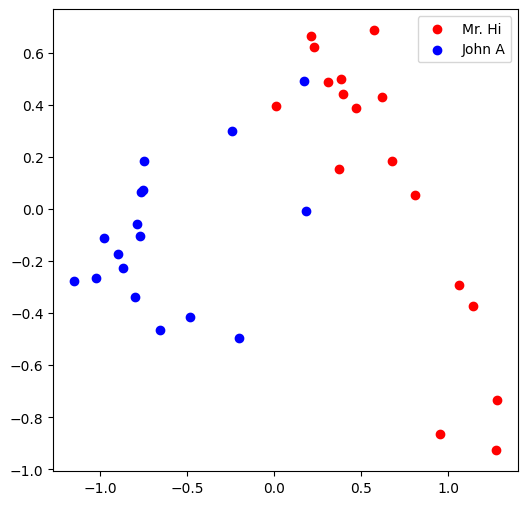

Эпоха 0: Ошибка = 538.916015625


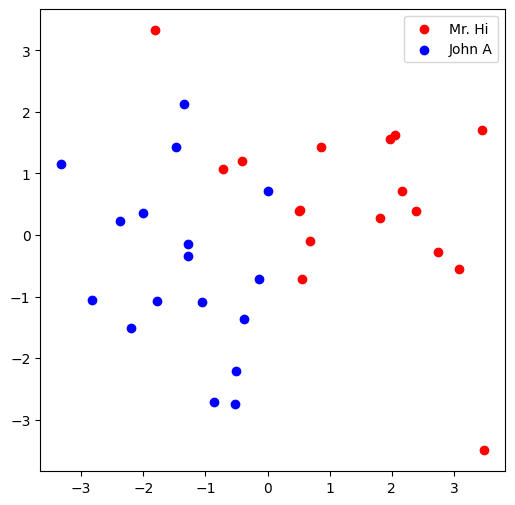

Эпоха 20: Ошибка = 183.0360870361328


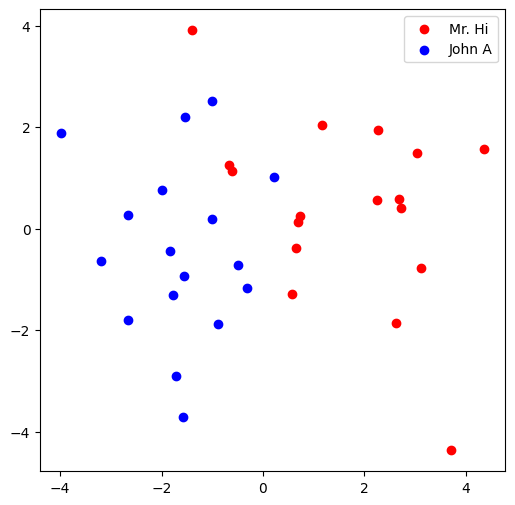

Эпоха 40: Ошибка = 165.99462890625


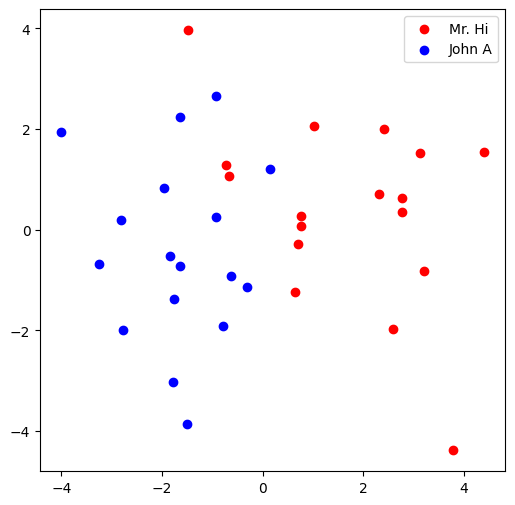

Эпоха 60: Ошибка = 163.87539672851562


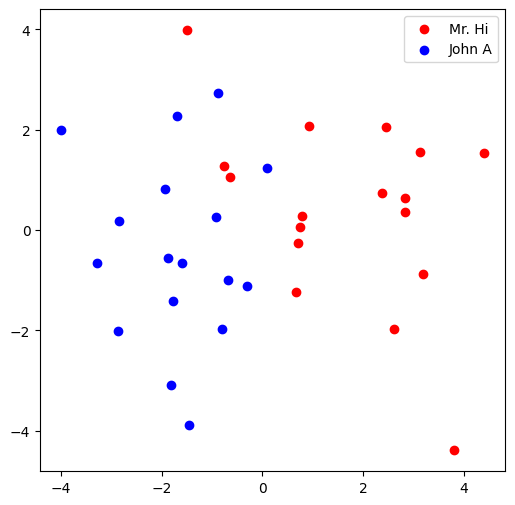

Эпоха 80: Ошибка = 163.5586700439453
Эпоха 99: Ошибка = 163.47695922851562


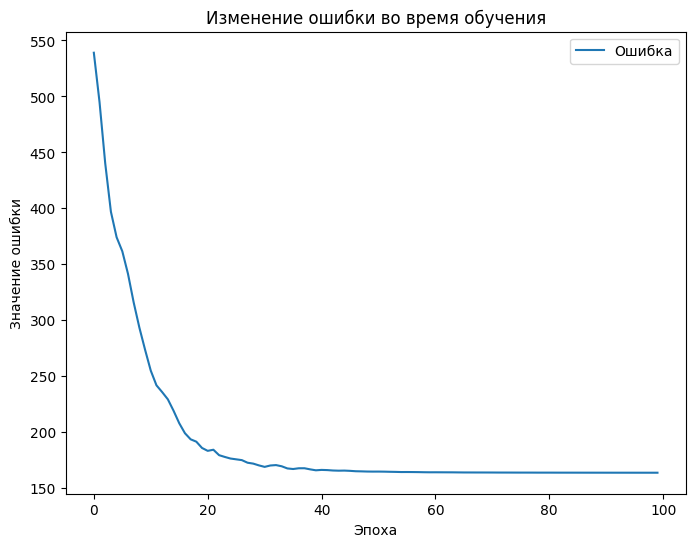

In [29]:
train(emb_n2v, pos_nodes_n2v, neg_nodes_n2v)

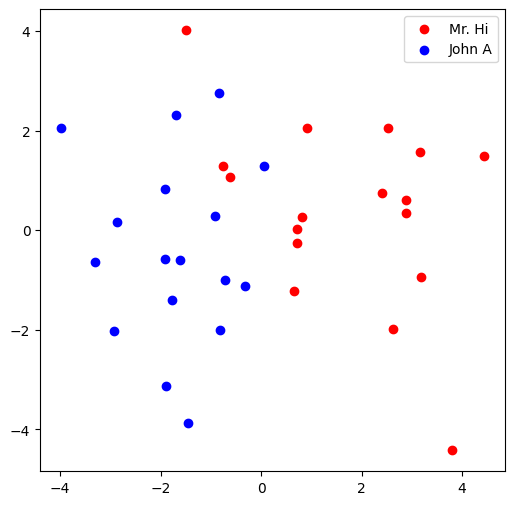

In [30]:
# Визуализация
visualize_emb(emb_n2v)

Основное различие между Node2Vec и DeepWalk заключается в том, как они выполняют случайные блуждания для генерации последовательностей узлов, которые впоследствии используются для обучения эмбеддингов. Оба алгоритма используют случайные блуждания, но Node2Vec предоставляет более гибкие параметры для настройки характера блужданий, позволяя достигать большего контроля над ходом этих блужданий.

**Основные отличия**
1. *Характер случайного блуждания*
*   DeepWalk использует простой случайный обход, где на каждом шаге выбирается один из соседей текущего узла с равной вероятностью. Таким образом, путь не имеет памяти — переход к узлу не зависит от того, из какого узла он пришел.
*   Node2Vec добавляет параметры 𝑝 и 𝑞, которые управляют вероятностью перехода к следующему узлу
2. *Производительность*
*   Node2Vec за счет дополнительных вычислений для каждого шага блуждания (учет параметров 𝑝 и 𝑞 может работать немного медленнее, чем DeepWalk.

________________________________________________




**Вывод:**

Алгоритм DeepWalk показал себя хуже при бинарной классификации вершин. Конечный лосс нескольно ниже: 175 против 163. Также при первичной инициализации loss у алгориьма DeepWalk был немного ниже: 536 против 538.

При этом визуальное разделение классов в алгоритме Node2Vec работает значительно хуже.